In [34]:
import h5py
import matplotlib.pyplot as plt
import mpl_lego as mplego
import neuropacks as packs
import numpy as np
import os
import pickle
from scipy.stats import bootstrap

from mpl_lego.ellipse import plot_cov_ellipse
from noise_correlations import analysis, utils
from settings import (colors, titles, ax_label_size, tick_label_size,
                      letter_size, legend_size, lw, line_alpha, fill_alpha)
from settings import (plot_lower, plot_upper, stats_frac_lower,
                      stats_frac_upper, select_lower, select_upper,
                      p_lower, p_upper, p_middle, stats_frac_middle,
                      ci, title_pad)

In [2]:
exp = 10
base_path = f"/storage/noise_correlations/exp{exp}"
grid_path = '/storage/noise_correlations/grdid.mat'
loc = 'data'
loc = 'noise_correlations'

In [3]:
ret2_path = os.path.join(base_path, f'exp{exp}_ret2_20_1000_1000.h5')
pvc11_1_path = os.path.join(base_path, f'exp{exp}_1_pvc11_20_1000_1000.h5')
ecog_path = os.path.join(base_path, f'exp{exp}_ecog_20_3000_1000.h5')
roi_path = os.path.join(f"/storage/{loc}/ret2/roi_positions.mat")
# Extra datasets
# pvc11_2_path = os.path.join(base_path, 'exp09_2_pvc11_15_1000_1000.h5')
# pvc11_3_path = os.path.join(base_path, 'exp09_3_pvc11_15_1000_1000.h5')

In [4]:
ret2 = h5py.File(ret2_path, 'r')
pvc11_1 = h5py.File(pvc11_1_path, 'r')
ecog = h5py.File(ecog_path, 'r')
results = [ret2, pvc11_1, ecog]

# Extra datasets
# pvc11_2 = h5py.File(pvc11_2_path, 'r')
# pvc11_3 = h5py.File(pvc11_3_path, 'r')

In [5]:
n_max_units = ret2['units'].shape[2]
dims = 3 + np.arange(n_max_units - 2)
n_results = len(results)

# Activity

In [6]:
# RET2
ret2_data_path = f'/storage/{loc}/ret2/200114_fov1_data.mat'
ret2_pack = packs.RET2(data_path=ret2_data_path)
X_ret2 = ret2_pack.get_response_matrix(cells='tuned', response='max')
# PVC11 - 1
pvc11_1_data_path = f'/storage/{loc}/pvc11/data/spikes_gratings/data_monkey1_gratings.mat'
pvc11_1_pack = packs.PVC11(data_path=pvc11_1_data_path)
X_pvc11 = pvc11_1_pack.get_response_matrix(transform=None)
# ECOG
ecog_data_path = f'/storage/{loc}/ecog/r32_b7.mat'
ecog_pack = packs.ECOG(data_path=ecog_data_path)
X_ecog = ecog_pack.get_response_matrix(bounds=[40, 60], band='HG', electrodes=ecog_pack.pac_idxs)

In [7]:
mu_ret2 = np.zeros((ret2_pack.n_angles, X_ret2.shape[1]))
mu_pvc11 = np.zeros((pvc11_1_pack.n_stimuli, X_pvc11.shape[1]))
mu_ecog = np.zeros((ecog_pack.freq_set.size, X_ecog.shape[1]))

for idx, angle in enumerate(ret2_pack.unique_angles):
    mu_ret2[idx] = X_ret2[ret2_pack.angles == angle].mean(axis=0)

for idx, angle in enumerate(pvc11_1_pack.get_angles()):
    mu_pvc11[idx] = X_pvc11[pvc11_1_pack.get_design_matrix() == angle].mean(axis=0)
    
for idx, frequency in enumerate(ecog_pack.freq_set):
    mu_ecog[idx] = X_ecog[ecog_pack.get_design_matrix('frequency') == frequency].mean(axis=0)

rank_ret2 = -np.argsort(mu_ret2, axis=0)
rank_pvc11 = -np.argsort(mu_pvc11, axis=0)
rank_ecog = -np.argsort(mu_ecog, axis=0)
ranks = [rank_ret2, rank_pvc11, rank_ecog]

In [8]:
avg_tuning_ranks = []
best_tuning_p_rank_fa = np.zeros((3, 18, 3))
best_tuning_p_rank_u = np.zeros((3, 18, 3))

for result_idx, (result, rank) in enumerate(zip(results, ranks)):
    n_dimstims = result['p_r_lfi'].shape[1]
    avg_tuning_ranks_temp = np.zeros((dims.size, n_dimstims))
    unique_stimuli = np.unique(result['stimuli'][:])

    for dim_idx, dim in enumerate(dims):
        for dimstim_idx in range(n_dimstims):
            units = result['units'][dim_idx, dimstim_idx][:dim]
            stims = result['stims'][dim_idx, dimstim_idx]
            rank1 = np.mean(rank[unique_stimuli == stims[0]][:, units])
            rank2 = np.mean(rank[unique_stimuli == stims[1]][:, units])
            total_rank = 0.5 * (rank1 + rank2)
            avg_tuning_ranks_temp[dim_idx, dimstim_idx] = total_rank
    avg_tuning_ranks.append(avg_tuning_ranks_temp)
    
    for dim_idx, dim in enumerate(dims):
        avg_rank_temp = avg_tuning_ranks[-1][dim_idx]
        rank_lower, rank_upper = np.percentile(avg_rank_temp, q=[select_lower, select_upper])
        p_fa_lfi_slice = result['p_fa_lfi'][dim_idx][(avg_rank_temp > rank_lower) &
                                                     (avg_rank_temp <= rank_upper)]
        p_u_lfi_slice = result['p_u_lfi'][dim_idx][(avg_rank_temp > rank_lower) &
                                                   (avg_rank_temp <= rank_upper)]
#         best_tuning_p_rank_fa[result_idx, dim_idx] = np.percentile(p_fa_lfi_slice, q=[stats_frac_lower,
#                                                                                       stats_frac_middle,
#                                                                                       stats_frac_upper])
#         best_tuning_p_rank_u[result_idx, dim_idx] = np.percentile(p_u_lfi_slice, q=[stats_frac_lower,
#                                                                                       stats_frac_middle,
#                                                                                       stats_frac_upper])
        best_tuning_p_rank_fa[result_idx, dim_idx] = utils.run_bootstrap(p_fa_lfi_slice, np.median, ci)
        best_tuning_p_rank_u[result_idx, dim_idx] = utils.run_bootstrap(p_u_lfi_slice, np.median, ci)

# Positions

In [9]:
with h5py.File(roi_path, 'r') as f:
    positions = f['xyPosDS'][:]
ret2_distances = np.linalg.norm(positions[:, :, np.newaxis] - positions[:, np.newaxis, :], axis=0)

In [10]:
positions = []
ecog_pack.read_grid(grid_path)
for idx in ecog_pack.pac_idxs:
    positions.append(ecog_pack.get_xy_for_electrode(idx))
positions = np.array(positions).T
ecog_distances = np.linalg.norm(positions[:, :, np.newaxis] - positions[:, np.newaxis, :], axis=0)

In [11]:
n_ret2_dimlets = 1000
n_ret2_dimstims = ret2['p_fa_lfi'].shape[1]
dimlet_distances = np.zeros((dims.size, n_ret2_dimstims))

units = ret2['units'][:]
for dim_idx, dim in enumerate(dims):
    for dimlet_idx in range(n_ret2_dimstims):
        unit_temp = units[dim_idx, dimlet_idx, :dim]
        tri_idx = np.triu_indices(dim, k=1)
        mean_dist = np.mean(ret2_distances[unit_temp][:, unit_temp][tri_idx])
        dimlet_distances[dim_idx, dimlet_idx] = mean_dist

ret2_rank_distances = np.argsort(-dimlet_distances, axis=1)

In [12]:
n_ecog_dimlets = 1000
n_ecog_dimstims = ecog['p_fa_lfi'].shape[1]
dimlet_distances = np.zeros((dims.size, n_ecog_dimstims))

units = ecog['units'][:]
for dim_idx, dim in enumerate(dims):
    for dimlet_idx in range(n_ecog_dimstims):
        unit_temp = units[dim_idx, dimlet_idx, :dim]
        tri_idx = np.triu_indices(dim, k=1)
        mean_dist = np.mean(ecog_distances[unit_temp][:, unit_temp][tri_idx])
        dimlet_distances[dim_idx, dimlet_idx] = mean_dist

ecog_rank_distances = np.argsort(-dimlet_distances, axis=1)

In [13]:
ret2_best_position_p_rank_fa = np.zeros((3, 18, 3))
ret2_best_position_p_rank_u = np.zeros((3, 18, 3))
ecog_best_position_p_rank_fa = np.zeros((3, 18, 3))
ecog_best_position_p_rank_u = np.zeros((3, 18, 3))

for dim_idx, dim in enumerate(dims):
    rank_temp = ret2_rank_distances[dim_idx]
    rank_lower, rank_upper = np.percentile(rank_temp, q=[select_lower, select_upper])
    p_fa_lfi_slice = ret2['p_fa_lfi'][dim_idx][(rank_temp > rank_lower) & (rank_temp <= rank_upper)]
    p_u_lfi_slice = ret2['p_u_lfi'][dim_idx][(rank_temp > rank_lower) & (rank_temp <= rank_upper)]
#     ret2_best_position_p_rank_fa[result_idx, dim_idx] = np.percentile(p_fa_lfi_slice, q=[stats_frac_lower,
#                                                                                       stats_frac_middle,
#                                                                                       stats_frac_upper])
#     ret2_best_position_p_rank_u[result_idx, dim_idx] = np.percentile(p_u_lfi_slice, q=[stats_frac_lower,
#                                                                                       stats_frac_middle,
#                                                                                       stats_frac_upper])
    ret2_best_position_p_rank_fa[result_idx, dim_idx] = utils.run_bootstrap(p_fa_lfi_slice, np.median, ci)
    ret2_best_position_p_rank_u[result_idx, dim_idx] = utils.run_bootstrap(p_u_lfi_slice, np.median, ci)
    
    rank_temp = ecog_rank_distances[dim_idx]
    rank_lower, rank_upper = np.percentile(rank_temp, q=[select_lower, select_upper])
    p_fa_lfi_slice = ecog['p_fa_lfi'][dim_idx][(rank_temp > rank_lower) & (rank_temp <= rank_upper)]
    p_u_lfi_slice = ecog['p_u_lfi'][dim_idx][(rank_temp > rank_lower) & (rank_temp <= rank_upper)]
#     ecog_best_position_p_rank_fa[result_idx, dim_idx] = np.percentile(p_fa_lfi_slice, q=[stats_frac_lower,
#                                                                                       stats_frac_middle,
#                                                                                       stats_frac_upper])
#     ecog_best_position_p_rank_u[result_idx, dim_idx] = np.percentile(p_u_lfi_slice, q=[stats_frac_lower,
#                                                                                       stats_frac_middle,
#                                                                                       stats_frac_upper])
    ecog_best_position_p_rank_fa[result_idx, dim_idx] = utils.run_bootstrap(p_fa_lfi_slice, np.median, ci)
    ecog_best_position_p_rank_u[result_idx, dim_idx] = utils.run_bootstrap(p_u_lfi_slice, np.median, ci)

# Fractions

In [14]:
fraction_fa = np.zeros((3, 18, 3))
fraction_u = np.zeros((3, 18, 3))

for idx, result in enumerate(results):
        percentiles = result['p_fa_lfi'][:]
        fraction_fa[idx] = utils.run_bootstrap(percentiles, utils.find_fraction, ci)

        percentiles = result['p_u_lfi'][:]
        fraction_u[idx] = utils.run_bootstrap(percentiles, utils.find_fraction, ci)

In [20]:
groups = [
    'v_lfi',
    'v_s_lfi',
    'v_u_lfi',
    'v_fa_lfi'
]
labels = [
    'Uniform',
    'FA'
]
percentile_groups = [
    'p_u_lfi',
    'p_fa_lfi'
]
models = [
    'uniform',
    'fa'
]

fractions = [fraction_u, fraction_fa]

0.024999999999999994 0.93
0.2983333333333333 0.93
0.5716666666666665 0.93
0.024999999999999994 0.4625
0.2983333333333333 0.4625
0.5716666666666665 0.4625


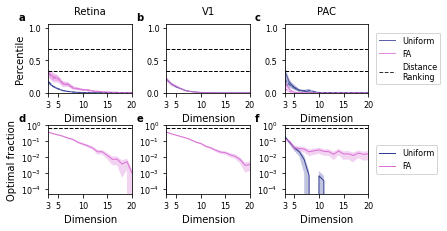

In [39]:
fig = plt.figure(figsize=(6, 3))

le = .095
re = .165
be = .125
te = .09
hg = .08
vg = .15
h = (1. - te - be - vg) / 2.
w = (1. - le - re - 2*hg) / 3.
axes = np.empty((2, 3), dtype=object)
axes[0] = [fig.add_axes([le + ii*(w + hg), be + h + vg, w, h]) for ii in range(3)]
axes[1] = [fig.add_axes([le + ii*(w + hg), be, w, h]) for ii in range(3)]

# Label adjustments
subplot_x = -0.18
subplot_y = 1.12
# Line settings
lw = 1
line_alpha = 0.8
# Fill settings
fill_alpha = 0.3
# Legend settings
handlelength = 0.3
handletextpad = 0.3

# Enumerate over results
for idx, result in enumerate(results):
    # Iterate over null models
    for group, model, label, fraction in zip(percentile_groups, models, labels, fractions):
        # Calculate median and bounds for each null model
        axes[1, idx].plot(
            dims,
            fraction[idx, :, 1],
            linewidth=lw,
            color=colors[model],
            label=label)
        axes[1, idx].fill_between(
        x=dims,
        y1=fraction[idx, :, 0],
        y2=fraction[idx, :, 2],
        color=colors[model],
        alpha=fill_alpha,
        ec='none')

    # Average rank over dimensions
    axes[0, idx].plot(
        dims,
        best_tuning_p_rank_u[idx, :, 1],
        linewidth=lw,
        alpha=line_alpha,
        color=colors['uniform'],
        label=labels[0] if idx ==2 else None)

    axes[0, idx].fill_between(
        x=dims,
        y1=best_tuning_p_rank_u[idx, :, 0],
        y2=best_tuning_p_rank_u[idx, :, 2],
        color=colors['uniform'],
        alpha=fill_alpha,
        ec='none')
    
        # Average rank over dimensions
    axes[0, idx].plot(
        dims,
        best_tuning_p_rank_fa[idx, :, 1],
        linewidth=lw,
        alpha=line_alpha,
        color=colors['fa'],
        label=labels[1] if idx ==2 else None)

    axes[0, idx].fill_between(
        x=dims,
        y1=best_tuning_p_rank_fa[idx, :, 0],
        y2=best_tuning_p_rank_fa[idx, :, 2],
        color=colors['fa'],
        alpha=fill_alpha,
        ec='none')

axes[0, 0].plot(
    dims,
    ret2_best_position_p_rank_u[idx, :, 1],
    linewidth=lw,
    linestyle='--',
    alpha=line_alpha,
    color=colors['uniform'])

axes[0, 0].fill_between(
    x=dims,
    y1=ret2_best_position_p_rank_u[idx, :, 0],
    y2=ret2_best_position_p_rank_u[idx, :, 2],
    color=colors['uniform'],
    hatch='//',
    alpha=fill_alpha,
    ec='none')

axes[0, 0].plot(
    dims,
    ret2_best_position_p_rank_fa[idx, :, 1],
    linewidth=lw,
    linestyle='--',
    alpha=line_alpha,
    color=colors['fa'])


axes[0, 0].fill_between(
    x=dims,
    y1=ret2_best_position_p_rank_fa[idx, :, 0],
    y2=ret2_best_position_p_rank_fa[idx, :, 2],
    color=colors['fa'],
    hatch='//',
    alpha=fill_alpha,
    ec='none')

axes[0, 2].plot(
    dims,
    ecog_best_position_p_rank_u[idx, :, 1],
    linewidth=lw,
    linestyle='--',
    alpha=line_alpha,
    color=colors['uniform'])

axes[0, 2].fill_between(
    x=dims,
    y1=ecog_best_position_p_rank_u[idx, :, 0],
    y2=ecog_best_position_p_rank_u[idx, :, 2],
    color=colors['uniform'],
    hatch='//',
    alpha=fill_alpha,
    ec='none')

axes[0, 2].plot(
    dims,
    ecog_best_position_p_rank_fa[idx, :, 1],
    linewidth=lw,
    linestyle='--',
    alpha=line_alpha,
    color=colors['fa'])
axes[0, 2].plot(
    [],
    [],
    linewidth=lw,
    linestyle='--',
    alpha=line_alpha,
    label='Distance\nRanking',
    color='k')

axes[0, 2].fill_between(
    x=dims,
    y1=ecog_best_position_p_rank_fa[idx, :, 0],
    y2=ecog_best_position_p_rank_fa[idx, :, 2],
    color=colors['fa'],
    hatch='//',
    alpha=fill_alpha,
    ec='none')
axes[0, 2].legend(
    loc='center left',
    bbox_to_anchor=(1.05, 0.5),
    prop={'size': legend_size})


for idx, ax in enumerate(axes[0]):
    ax.set_ylim([0, 1.05])
    ax.set_yticks([0, .5, 1])
    ax.axhline(plot_lower, linestyle='--', color='k', lw=lw)
    ax.axhline(plot_upper, linestyle='--', color='k', lw=lw)
    ax.set_title(titles[idx], fontsize=ax_label_size, pad=title_pad)
axes[0, 0].set_ylabel('Percentile', fontsize=ax_label_size)

for idx, ax in enumerate(axes[1].ravel()):
    ax.set_ylim([5e-5, 1.])
    ax.set_yscale('log')
    ax.set_yticks([1e-4, 1e-3, 1e-2, 1e-1, 1])
    ax.axhline(plot_upper, linestyle='--', color='k', lw=lw)
axes[1, 0].set_ylabel('Optimal fraction', fontsize=ax_label_size)
    
for idx, ax in enumerate(axes.ravel()):
    ax.set_xlim([3, 20])
    ax.set_xticks([3, 5, 10, 15, 20])
    ax.tick_params(labelsize=tick_label_size)
    ax.set_xlabel('Dimension', fontsize=ax_label_size)
    

axes[1, 2].legend(
    loc='center left',
    bbox_to_anchor=(1.05, 0.5),
    prop={'size': legend_size})

lets = ['a', 'b', 'c', 'd', 'e', 'f']
c = 0
for y in [1. - te - jj*(vg + h) + .02 for jj in range(2)]:
    for ii, x in enumerate([le + ii*(w + hg) - .07 for ii in range(3)]):
        print(x, y)
        fig.text(x, y, lets[c], size=letter_size, fontweight='bold')
        c += 1

plt.savefig('figure5.pdf', dpi=300)
plt.savefig('figure5.jpg', dpi=300)